In [ ]:
import os
current_working_directory = os.getcwd()
print(current_working_directory)

import matplotlib.pyplot as plt
import numpy as np 
import torch 
import torch.nn as nn 
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader
import scipy.io as sio

from tqdm import trange, tqdm

# Import the quadruped model components from your second file
from Quadruped_qp.mlp_quadruped_rnn import MLP, MLPQuadrupedProjectionFilter, CustomGRULayer, GRU_Hidden_State
from stance_leg_controller import ForceStanceLegController

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

/home/alinjar/simple_training_warm_start/qp
Using cuda device


In [2]:
class ForceDataset(Dataset):
    """Expert Trajectory Dataset."""
    def __init__(self, inp):
        # input
        self.inp = inp

    def __len__(self):
        return len(self.inp)    
        
    def __getitem__(self, idx):
        # Input
        inp = self.inp[idx]
        return torch.tensor(inp).float()    

def sample_uniform_forces(key, F_max, num_batch, nvar):
    rng = np.random.default_rng(seed=key)
    xi_samples = rng.uniform(
        low=-F_max,
        high=F_max,
        size=(num_batch, nvar)
    )
    return xi_samples, rng

In [3]:
# Parameters for Quadruped Model
num_batch = 1000
timestep = 0.05  # 50 Hz control frequency
horizon = 10     # prediction horizon steps
num_legs = 4
friction_coeff = 0.2
body_mass = 50.0  # kg

body_inertia=(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)

# Desired motion parameters
desired_speed = (0.0, 0.0)        # m/s
desired_twisting_speed = 0.5  # rad/s
desired_body_height = 0.5     # m

# Force limits
F_max = 100.0  # Maximum force magnitude for sampling

# Problem dimensions for quadruped force control


##Parameters for MLP model
# Default states
BaseRollPitchYaw = (0.0, 0.0, 0.0)
AngularVelocityBodyFrame = (0.0, 0.0, 0.0)
ComVelocityBodyFrame = (0.0, 0.0, 0.0)
FootContacts = (True, True, True, True)
slope_estimate = (0.0, 0.0, 0.0)
RotationBodyWrtWorld = (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)

In [4]:
"""Setup foot positions and default states for quadruped"""
# Foot positions in body frame
foot_x=0.2
foot_y=0.2
foot_z=-desired_body_height

FootPositionsInBodyFrame = torch.tensor([
    [ foot_x,  foot_y, foot_z],
    [-foot_x,  foot_y, foot_z],
    [ foot_x, -foot_y, foot_z],
    [-foot_x, -foot_y, foot_z]])

# Define QP matrices for quadruped control (simplified example)
# In practice, these would come from your quadruped dynamics model
controller = ForceStanceLegController(
    desired_speed=desired_speed,
    desired_twisting_speed=desired_twisting_speed,
    desired_body_height=desired_body_height,
    body_mass=body_mass,
    body_inertia=body_inertia,
    num_legs=num_legs,
    friction_coeff=friction_coeff,
    timestep=timestep,
    horizon=horizon
)

# Get QP matrices
H, g, C, c = controller.getMatrices(
    BaseRollPitchYaw=BaseRollPitchYaw,
    AngularVelocityBodyFrame=AngularVelocityBodyFrame,
    ComVelocityBodyFrame=ComVelocityBodyFrame,
    FootPositionsInBodyFrame=FootPositionsInBodyFrame,
    FootContacts=FootContacts,
    slope_estimate=slope_estimate,
    RotationBodyWrtWorld=RotationBodyWrtWorld
)


# Store matrices
H = H                       # QP Hessian (3nk x 3nk)
g = g                       # Linear term (3nk)
C = C                       # Constraint matrix (num_total_constraints x 3nk)
c_lower = c                       # Lower bound (num_total_constraints)
c_upper = -c                     # Upper bound (num_total_constraints)

# Maximum Iterations
maxiter_projection = 20

In [5]:
nvar = H.shape[0]
C_torch = torch.from_numpy(C).float().to(device)
A_control = torch.vstack((C_torch, -C_torch))


num_total_constraints = A_control.shape[0]

# Generate training and validation data
xi_samples, rng = sample_uniform_forces(42, F_max, num_batch, nvar)
xi_val, rng_val = sample_uniform_forces(43, F_max, num_batch, nvar)

inp = xi_samples
inp_val = xi_val

# Using PyTorch Dataloader
train_dataset = ForceDataset(inp)
val_dataset = ForceDataset(inp_val)

train_loader = DataLoader(train_dataset, batch_size=num_batch, shuffle=True, num_workers=0, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=num_batch, shuffle=True, num_workers=0, drop_last=True)

# GRU handling
gru_input_size = 3 * num_total_constraints + 3 * nvar
gru_hidden_size = 512
gru_output_size = num_total_constraints + nvar

gru_context = CustomGRULayer(gru_input_size, gru_hidden_size, gru_output_size)

input_hidden_state_init = np.shape(inp)[1]
mid_hidden_state_init = 512
out_hidden_state_init = gru_hidden_size

gru_init = GRU_Hidden_State(input_hidden_state_init, mid_hidden_state_init, out_hidden_state_init)

# MLP setup
enc_inp_dim = np.shape(inp)[1] 
mlp_inp_dim = enc_inp_dim
hidden_dim = 1024
mlp_out_dim = 2*nvar + num_total_constraints  # xi_samples, lambda_samples, slack_variables

mlp = MLP(mlp_inp_dim, hidden_dim, mlp_out_dim)

In [6]:
# Create the quadruped model
model = MLPQuadrupedProjectionFilter(
    mlp=mlp,
    gru_context=gru_context, 
    gru_init=gru_init, 
    num_batch=num_batch,
    H=H, 
    g=g, 
    C=C, 
    c_lower=c_lower, 
    c_upper=c_upper, 
    maxiter_projection=maxiter_projection,
    desired_speed=desired_speed,
    desired_twisting_speed=desired_twisting_speed,
    desired_body_height=desired_body_height,
    body_mass=body_mass,
    body_inertia=body_inertia,
    num_legs=num_legs,
    friction_coeff=friction_coeff,
    timestep=timestep,
    horizon=horizon).to(device)

print(f"Model type: {type(model)}")
print(f"Number of parameters: {sum(p.numel() for p in model.parameters())}")

Problem dimensions:
H matrix shape: torch.Size([120, 120])
g vector shape: torch.Size([120])
C matrix shape: torch.Size([240, 120])
Number of variables: 120
Number of constraints: 480
Model type: <class 'mlp_quadruped_gru.MLPQuadrupedProjectionFilter'>
Number of parameters: 6339624


In [7]:
# Training
epochs = 500
optimizer = optim.AdamW(model.parameters(), lr=1e-2, weight_decay=1e-3)

losses = []
last_loss = torch.inf
avg_train_loss, avg_primal_loss, avg_fixed_point_loss, avg_projection_loss = [], [], [], []
avg_val_loss = []

for epoch in range(epochs):
    
    # Train Loop
    model.train()
    losses_train, primal_losses, fixed_point_losses, projection_losses = [], [], [], []
    
    for (inp) in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        
        # Input and Output 
        inp = inp.to(device)
        
        # Forward pass through quadruped model
        xi_projected, avg_res_fixed_point, avg_res_primal, res_primal_history, res_fixed_point_history = model(inp)
        
        # Compute loss
        primal_loss, fixed_point_loss, projection_loss, loss = model.mlp_loss(
            avg_res_primal, avg_res_fixed_point, inp, xi_projected)

        optimizer.zero_grad()
        loss.backward()
        
        # Optional gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        
        losses_train.append(loss.detach().cpu().numpy()) 
        primal_losses.append(primal_loss.detach().cpu().numpy())
        fixed_point_losses.append(fixed_point_loss.detach().cpu().numpy())
        projection_losses.append(projection_loss.detach().cpu().numpy())
        
    # Validation every 2 epochs
    if epoch % 2 == 0:
        model.eval()
        val_losses = []

        with torch.no_grad():
            for (inp_val) in tqdm(val_loader, desc="Validation"):
                inp_val = inp_val.to(device)

                xi_projected, avg_res_fixed_point, avg_res_primal, res_primal_history, res_fixed_point_history = model(inp_val)

                _, _, _, val_loss = model.mlp_loss(
                    avg_res_primal, avg_res_fixed_point, inp_val, xi_projected
                )

                val_losses.append(val_loss.detach().cpu().numpy())

    # Print progress every 2 epochs
    if epoch % 2 == 0:    
        print(f"Epoch: {epoch + 1}")
        
        # if len(val_losses) > 0:
        #     print(f"Validation Loss: {np.average(val_losses):.4f}")

    # Save best model
    os.makedirs("./training_weights", exist_ok=True)
    if loss <= last_loss:
        torch.save(model.state_dict(), f"./training_weights/mlp_learned_quadruped_gru.pth")
        last_loss = loss

    # Store metrics
    avg_train_loss.append(np.average(losses_train))
    avg_primal_loss.append(np.average(primal_losses))
    avg_projection_loss.append(np.average(projection_losses))
    avg_fixed_point_loss.append(np.average(fixed_point_losses))
    
    if len(val_losses) > 0:
        avg_val_loss.append(np.average(val_losses))
    else:
        avg_val_loss.append(avg_val_loss[-1] if avg_val_loss else 0.0)

print("Training completed!")



Validation: 100%|██████████| 1/1 [00:00<00:00, 50.22it/s]


Epoch: 1


Validation: 100%|██████████| 1/1 [00:00<00:00, 54.96it/s]


Epoch: 3


Validation: 100%|██████████| 1/1 [00:00<00:00, 55.36it/s]


Epoch: 5


Validation: 100%|██████████| 1/1 [00:00<00:00, 58.16it/s]


Epoch: 7


Validation: 100%|██████████| 1/1 [00:00<00:00, 56.36it/s]


Epoch: 9


Validation: 100%|██████████| 1/1 [00:00<00:00, 57.55it/s]


Epoch: 11


Validation: 100%|██████████| 1/1 [00:00<00:00, 57.02it/s]


Epoch: 13


Validation: 100%|██████████| 1/1 [00:00<00:00, 54.33it/s]


Epoch: 15


Validation: 100%|██████████| 1/1 [00:00<00:00, 54.58it/s]


Epoch: 17


Validation: 100%|██████████| 1/1 [00:00<00:00, 41.57it/s]


Epoch: 19


Validation: 100%|██████████| 1/1 [00:00<00:00, 52.84it/s]


Epoch: 21


Validation: 100%|██████████| 1/1 [00:00<00:00, 56.54it/s]


Epoch: 23


Validation: 100%|██████████| 1/1 [00:00<00:00, 54.82it/s]


Epoch: 25


Validation: 100%|██████████| 1/1 [00:00<00:00, 55.03it/s]


Epoch: 27


Validation: 100%|██████████| 1/1 [00:00<00:00, 54.16it/s]


Epoch: 29


Validation: 100%|██████████| 1/1 [00:00<00:00, 55.61it/s]


Epoch: 31


Validation: 100%|██████████| 1/1 [00:00<00:00, 58.47it/s]


Epoch: 33


Validation: 100%|██████████| 1/1 [00:00<00:00, 58.09it/s]


Epoch: 35


Validation: 100%|██████████| 1/1 [00:00<00:00, 56.07it/s]


Epoch: 37


Validation: 100%|██████████| 1/1 [00:00<00:00, 54.04it/s]


Epoch: 39


Validation: 100%|██████████| 1/1 [00:00<00:00, 58.31it/s]


Epoch: 41


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.69it/s]


Epoch: 43


Validation: 100%|██████████| 1/1 [00:00<00:00, 41.41it/s]


Epoch: 45


Validation: 100%|██████████| 1/1 [00:00<00:00, 52.73it/s]


Epoch: 47


Validation: 100%|██████████| 1/1 [00:00<00:00, 57.20it/s]


Epoch: 49


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.48it/s]


Epoch: 51


Validation: 100%|██████████| 1/1 [00:00<00:00, 57.01it/s]


Epoch: 53


Validation: 100%|██████████| 1/1 [00:00<00:00, 43.33it/s]


Epoch: 55


Validation: 100%|██████████| 1/1 [00:00<00:00, 58.06it/s]


Epoch: 57


Validation: 100%|██████████| 1/1 [00:00<00:00, 57.83it/s]


Epoch: 59


Validation: 100%|██████████| 1/1 [00:00<00:00, 54.65it/s]


Epoch: 61


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.18it/s]


Epoch: 63


Validation: 100%|██████████| 1/1 [00:00<00:00, 55.60it/s]


Epoch: 65


Validation: 100%|██████████| 1/1 [00:00<00:00, 53.43it/s]


Epoch: 67


Validation: 100%|██████████| 1/1 [00:00<00:00, 58.34it/s]


Epoch: 69


Validation: 100%|██████████| 1/1 [00:00<00:00, 55.07it/s]


Epoch: 71


Validation: 100%|██████████| 1/1 [00:00<00:00, 55.43it/s]


Epoch: 73


Validation: 100%|██████████| 1/1 [00:00<00:00, 55.94it/s]


Epoch: 75


Validation: 100%|██████████| 1/1 [00:00<00:00, 56.22it/s]


Epoch: 77


Validation: 100%|██████████| 1/1 [00:00<00:00, 53.84it/s]


Epoch: 79


Validation: 100%|██████████| 1/1 [00:00<00:00, 53.19it/s]


Epoch: 81


Validation: 100%|██████████| 1/1 [00:00<00:00, 55.08it/s]


Epoch: 83


Validation: 100%|██████████| 1/1 [00:00<00:00, 54.03it/s]


Epoch: 85


Validation: 100%|██████████| 1/1 [00:00<00:00, 46.19it/s]


Epoch: 87


Validation: 100%|██████████| 1/1 [00:00<00:00, 56.02it/s]


Epoch: 89


Validation: 100%|██████████| 1/1 [00:00<00:00, 52.64it/s]


Epoch: 91


Validation: 100%|██████████| 1/1 [00:00<00:00, 56.11it/s]


Epoch: 93


Validation: 100%|██████████| 1/1 [00:00<00:00, 54.16it/s]


Epoch: 95


Validation: 100%|██████████| 1/1 [00:00<00:00, 56.13it/s]


Epoch: 97


Validation: 100%|██████████| 1/1 [00:00<00:00, 56.45it/s]


Epoch: 99


Validation: 100%|██████████| 1/1 [00:00<00:00, 58.82it/s]


Epoch: 101


Validation: 100%|██████████| 1/1 [00:00<00:00, 54.00it/s]


Epoch: 103


Validation: 100%|██████████| 1/1 [00:00<00:00, 57.68it/s]


Epoch: 105


Validation: 100%|██████████| 1/1 [00:00<00:00, 56.72it/s]


Epoch: 107


Validation: 100%|██████████| 1/1 [00:00<00:00, 57.72it/s]


Epoch: 109


Validation: 100%|██████████| 1/1 [00:00<00:00, 53.24it/s]


Epoch: 111


Validation: 100%|██████████| 1/1 [00:00<00:00, 54.11it/s]


Epoch: 113


Validation: 100%|██████████| 1/1 [00:00<00:00, 55.48it/s]


Epoch: 115


Validation: 100%|██████████| 1/1 [00:00<00:00, 56.67it/s]


Epoch: 117


Validation: 100%|██████████| 1/1 [00:00<00:00, 53.85it/s]


Epoch: 119


Validation: 100%|██████████| 1/1 [00:00<00:00, 41.81it/s]


Epoch: 121


Validation: 100%|██████████| 1/1 [00:00<00:00, 48.70it/s]


Epoch: 123


Validation: 100%|██████████| 1/1 [00:00<00:00, 53.83it/s]


Epoch: 125


Validation: 100%|██████████| 1/1 [00:00<00:00, 46.53it/s]


Epoch: 127


Validation: 100%|██████████| 1/1 [00:00<00:00, 52.62it/s]


Epoch: 129


Validation: 100%|██████████| 1/1 [00:00<00:00, 48.70it/s]


Epoch: 131


Validation: 100%|██████████| 1/1 [00:00<00:00, 55.31it/s]


Epoch: 133


Validation: 100%|██████████| 1/1 [00:00<00:00, 56.03it/s]


Epoch: 135


Validation: 100%|██████████| 1/1 [00:00<00:00, 54.11it/s]


Epoch: 137


Validation: 100%|██████████| 1/1 [00:00<00:00, 54.08it/s]


Epoch: 139


Validation: 100%|██████████| 1/1 [00:00<00:00, 53.10it/s]


Epoch: 141


Validation: 100%|██████████| 1/1 [00:00<00:00, 43.55it/s]


Epoch: 143


Validation: 100%|██████████| 1/1 [00:00<00:00, 53.74it/s]


Epoch: 145


Validation: 100%|██████████| 1/1 [00:00<00:00, 48.32it/s]


Epoch: 147


Validation: 100%|██████████| 1/1 [00:00<00:00, 54.35it/s]


Epoch: 149


Validation: 100%|██████████| 1/1 [00:00<00:00, 59.04it/s]


Epoch: 151


Validation: 100%|██████████| 1/1 [00:00<00:00, 52.78it/s]


Epoch: 153


Validation: 100%|██████████| 1/1 [00:00<00:00, 48.81it/s]


Epoch: 155


Validation: 100%|██████████| 1/1 [00:00<00:00, 55.33it/s]


Epoch: 157


Validation: 100%|██████████| 1/1 [00:00<00:00, 52.50it/s]


Epoch: 159


Validation: 100%|██████████| 1/1 [00:00<00:00, 56.59it/s]


Epoch: 161


Validation: 100%|██████████| 1/1 [00:00<00:00, 55.98it/s]


Epoch: 163


Validation: 100%|██████████| 1/1 [00:00<00:00, 54.06it/s]


Epoch: 165


Validation: 100%|██████████| 1/1 [00:00<00:00, 56.99it/s]


Epoch: 167


Validation: 100%|██████████| 1/1 [00:00<00:00, 59.42it/s]


Epoch: 169


Validation: 100%|██████████| 1/1 [00:00<00:00, 56.11it/s]


Epoch: 171


Validation: 100%|██████████| 1/1 [00:00<00:00, 53.03it/s]


Epoch: 173


Validation: 100%|██████████| 1/1 [00:00<00:00, 59.53it/s]


Epoch: 175


Validation: 100%|██████████| 1/1 [00:00<00:00, 53.92it/s]


Epoch: 177


Validation: 100%|██████████| 1/1 [00:00<00:00, 54.95it/s]


Epoch: 179


Validation: 100%|██████████| 1/1 [00:00<00:00, 54.02it/s]


Epoch: 181


Validation: 100%|██████████| 1/1 [00:00<00:00, 55.35it/s]


Epoch: 183


Validation: 100%|██████████| 1/1 [00:00<00:00, 54.01it/s]


Epoch: 185


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.24it/s]


Epoch: 187


Validation: 100%|██████████| 1/1 [00:00<00:00, 53.33it/s]


Epoch: 189


Validation: 100%|██████████| 1/1 [00:00<00:00, 53.23it/s]


Epoch: 191


Validation: 100%|██████████| 1/1 [00:00<00:00, 54.10it/s]


Epoch: 193


Validation: 100%|██████████| 1/1 [00:00<00:00, 54.98it/s]


Epoch: 195


Validation: 100%|██████████| 1/1 [00:00<00:00, 47.10it/s]


Epoch: 197


Validation: 100%|██████████| 1/1 [00:00<00:00, 53.05it/s]


Epoch: 199


Validation: 100%|██████████| 1/1 [00:00<00:00, 48.19it/s]


Epoch: 201


Validation: 100%|██████████| 1/1 [00:00<00:00, 55.26it/s]


Epoch: 203


Validation: 100%|██████████| 1/1 [00:00<00:00, 55.07it/s]


Epoch: 205


Validation: 100%|██████████| 1/1 [00:00<00:00, 54.17it/s]


Epoch: 207


Validation: 100%|██████████| 1/1 [00:00<00:00, 47.77it/s]


Epoch: 209


Validation: 100%|██████████| 1/1 [00:00<00:00, 54.16it/s]


Epoch: 211


Validation: 100%|██████████| 1/1 [00:00<00:00, 56.62it/s]


Epoch: 213


Validation: 100%|██████████| 1/1 [00:00<00:00, 52.98it/s]


Epoch: 215


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.13it/s]


Epoch: 217


Validation: 100%|██████████| 1/1 [00:00<00:00, 57.39it/s]


Epoch: 219


Validation: 100%|██████████| 1/1 [00:00<00:00, 53.98it/s]


Epoch: 221


Validation: 100%|██████████| 1/1 [00:00<00:00, 55.64it/s]


Epoch: 223


Validation: 100%|██████████| 1/1 [00:00<00:00, 57.60it/s]


Epoch: 225


Validation: 100%|██████████| 1/1 [00:00<00:00, 56.09it/s]


Epoch: 227


Validation: 100%|██████████| 1/1 [00:00<00:00, 56.26it/s]


Epoch: 229


Validation: 100%|██████████| 1/1 [00:00<00:00, 56.89it/s]


Epoch: 231


Validation: 100%|██████████| 1/1 [00:00<00:00, 55.57it/s]


Epoch: 233


Validation: 100%|██████████| 1/1 [00:00<00:00, 55.32it/s]


Epoch: 235


Validation: 100%|██████████| 1/1 [00:00<00:00, 56.75it/s]


Epoch: 237


Validation: 100%|██████████| 1/1 [00:00<00:00, 55.07it/s]


Epoch: 239


Validation: 100%|██████████| 1/1 [00:00<00:00, 56.86it/s]


Epoch: 241


Validation: 100%|██████████| 1/1 [00:00<00:00, 57.27it/s]


Epoch: 243


Validation: 100%|██████████| 1/1 [00:00<00:00, 55.33it/s]


Epoch: 245


Validation: 100%|██████████| 1/1 [00:00<00:00, 54.39it/s]


Epoch: 247


Validation: 100%|██████████| 1/1 [00:00<00:00, 55.50it/s]


Epoch: 249


Validation: 100%|██████████| 1/1 [00:00<00:00, 57.33it/s]


Epoch: 251


Validation: 100%|██████████| 1/1 [00:00<00:00, 52.96it/s]


Epoch: 253


Validation: 100%|██████████| 1/1 [00:00<00:00, 53.86it/s]


Epoch: 255


Validation: 100%|██████████| 1/1 [00:00<00:00, 57.49it/s]


Epoch: 257


Validation: 100%|██████████| 1/1 [00:00<00:00, 54.44it/s]


Epoch: 259


Validation: 100%|██████████| 1/1 [00:00<00:00, 55.58it/s]


Epoch: 261


Validation: 100%|██████████| 1/1 [00:00<00:00, 41.84it/s]


Epoch: 263


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.84it/s]


Epoch: 265


Validation: 100%|██████████| 1/1 [00:00<00:00, 56.45it/s]


Epoch: 267


Validation: 100%|██████████| 1/1 [00:00<00:00, 55.60it/s]


Epoch: 269


Validation: 100%|██████████| 1/1 [00:00<00:00, 54.24it/s]


Epoch: 271


Validation: 100%|██████████| 1/1 [00:00<00:00, 45.47it/s]


Epoch: 273


Validation: 100%|██████████| 1/1 [00:00<00:00, 53.53it/s]


Epoch: 275


Validation: 100%|██████████| 1/1 [00:00<00:00, 55.99it/s]


Epoch: 277


Validation: 100%|██████████| 1/1 [00:00<00:00, 55.09it/s]


Epoch: 279


Validation: 100%|██████████| 1/1 [00:00<00:00, 53.32it/s]


Epoch: 281


Validation: 100%|██████████| 1/1 [00:00<00:00, 56.22it/s]


Epoch: 283


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.95it/s]


Epoch: 285


Validation: 100%|██████████| 1/1 [00:00<00:00, 53.76it/s]


Epoch: 287


Validation: 100%|██████████| 1/1 [00:00<00:00, 53.00it/s]


Epoch: 289


Validation: 100%|██████████| 1/1 [00:00<00:00, 54.53it/s]


Epoch: 291


Validation: 100%|██████████| 1/1 [00:00<00:00, 54.31it/s]


Epoch: 293


Validation: 100%|██████████| 1/1 [00:00<00:00, 56.01it/s]


Epoch: 295


Validation: 100%|██████████| 1/1 [00:00<00:00, 56.32it/s]


Epoch: 297


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.43it/s]


Epoch: 299


Validation: 100%|██████████| 1/1 [00:00<00:00, 54.29it/s]


Epoch: 301


Validation: 100%|██████████| 1/1 [00:00<00:00, 54.12it/s]


Epoch: 303


Validation: 100%|██████████| 1/1 [00:00<00:00, 56.33it/s]


Epoch: 305


Validation: 100%|██████████| 1/1 [00:00<00:00, 53.85it/s]


Epoch: 307


Validation: 100%|██████████| 1/1 [00:00<00:00, 54.23it/s]


Epoch: 309


Validation: 100%|██████████| 1/1 [00:00<00:00, 56.17it/s]


Epoch: 311


Validation: 100%|██████████| 1/1 [00:00<00:00, 58.67it/s]


Epoch: 313


Validation: 100%|██████████| 1/1 [00:00<00:00, 52.87it/s]


Epoch: 315


Validation: 100%|██████████| 1/1 [00:00<00:00, 55.16it/s]


Epoch: 317


Validation: 100%|██████████| 1/1 [00:00<00:00, 56.04it/s]


Epoch: 319


Validation: 100%|██████████| 1/1 [00:00<00:00, 53.74it/s]


Epoch: 321


Validation: 100%|██████████| 1/1 [00:00<00:00, 56.17it/s]


Epoch: 323


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.35it/s]


Epoch: 325


Validation: 100%|██████████| 1/1 [00:00<00:00, 54.39it/s]


Epoch: 327


Validation: 100%|██████████| 1/1 [00:00<00:00, 53.35it/s]


Epoch: 329


Validation: 100%|██████████| 1/1 [00:00<00:00, 54.99it/s]


Epoch: 331


Validation: 100%|██████████| 1/1 [00:00<00:00, 52.14it/s]


Epoch: 333


Validation: 100%|██████████| 1/1 [00:00<00:00, 56.07it/s]


Epoch: 335


Validation: 100%|██████████| 1/1 [00:00<00:00, 56.23it/s]


Epoch: 337


Validation: 100%|██████████| 1/1 [00:00<00:00, 54.54it/s]


Epoch: 339


Validation: 100%|██████████| 1/1 [00:00<00:00, 43.87it/s]


Epoch: 341


Validation: 100%|██████████| 1/1 [00:00<00:00, 46.65it/s]


Epoch: 343


Validation: 100%|██████████| 1/1 [00:00<00:00, 55.29it/s]


Epoch: 345


Validation: 100%|██████████| 1/1 [00:00<00:00, 55.91it/s]


Epoch: 347


Validation: 100%|██████████| 1/1 [00:00<00:00, 53.76it/s]


Epoch: 349


Validation: 100%|██████████| 1/1 [00:00<00:00, 55.92it/s]


Epoch: 351


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.92it/s]


Epoch: 353


Validation: 100%|██████████| 1/1 [00:00<00:00, 43.90it/s]


Epoch: 355


Validation: 100%|██████████| 1/1 [00:00<00:00, 54.00it/s]


Epoch: 357


Validation: 100%|██████████| 1/1 [00:00<00:00, 57.16it/s]


Epoch: 359


Validation: 100%|██████████| 1/1 [00:00<00:00, 58.05it/s]


Epoch: 361


Validation: 100%|██████████| 1/1 [00:00<00:00, 52.70it/s]


Epoch: 363


Validation: 100%|██████████| 1/1 [00:00<00:00, 56.33it/s]


Epoch: 365


Validation: 100%|██████████| 1/1 [00:00<00:00, 55.04it/s]


Epoch: 367


Validation: 100%|██████████| 1/1 [00:00<00:00, 55.30it/s]


Epoch: 369


Validation: 100%|██████████| 1/1 [00:00<00:00, 52.81it/s]


Epoch: 371


Validation: 100%|██████████| 1/1 [00:00<00:00, 54.50it/s]


Epoch: 373


Validation: 100%|██████████| 1/1 [00:00<00:00, 42.55it/s]


Epoch: 375


Validation: 100%|██████████| 1/1 [00:00<00:00, 46.30it/s]


Epoch: 377


Validation: 100%|██████████| 1/1 [00:00<00:00, 57.03it/s]


Epoch: 379


Validation: 100%|██████████| 1/1 [00:00<00:00, 40.98it/s]


Epoch: 381


Validation: 100%|██████████| 1/1 [00:00<00:00, 53.50it/s]


Epoch: 383


Validation: 100%|██████████| 1/1 [00:00<00:00, 57.77it/s]


Epoch: 385


Validation: 100%|██████████| 1/1 [00:00<00:00, 55.62it/s]


Epoch: 387


Validation: 100%|██████████| 1/1 [00:00<00:00, 53.62it/s]


Epoch: 389


Validation: 100%|██████████| 1/1 [00:00<00:00, 52.42it/s]


Epoch: 391


Validation: 100%|██████████| 1/1 [00:00<00:00, 54.00it/s]


Epoch: 393


Validation: 100%|██████████| 1/1 [00:00<00:00, 52.69it/s]


Epoch: 395


Validation: 100%|██████████| 1/1 [00:00<00:00, 55.56it/s]


Epoch: 397


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.74it/s]


Epoch: 399


Validation: 100%|██████████| 1/1 [00:00<00:00, 56.37it/s]


Epoch: 401


Validation: 100%|██████████| 1/1 [00:00<00:00, 56.39it/s]


Epoch: 403


Validation: 100%|██████████| 1/1 [00:00<00:00, 48.52it/s]


Epoch: 405


Validation: 100%|██████████| 1/1 [00:00<00:00, 53.08it/s]


Epoch: 407


Validation: 100%|██████████| 1/1 [00:00<00:00, 54.50it/s]


Epoch: 409


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.23it/s]


Epoch: 411


Validation: 100%|██████████| 1/1 [00:00<00:00, 54.81it/s]


Epoch: 413


Validation: 100%|██████████| 1/1 [00:00<00:00, 53.08it/s]


Epoch: 415


Validation: 100%|██████████| 1/1 [00:00<00:00, 54.94it/s]


Epoch: 417


Validation: 100%|██████████| 1/1 [00:00<00:00, 56.50it/s]


Epoch: 419


Validation: 100%|██████████| 1/1 [00:00<00:00, 54.05it/s]


Epoch: 421


Validation: 100%|██████████| 1/1 [00:00<00:00, 53.08it/s]


Epoch: 423


Validation: 100%|██████████| 1/1 [00:00<00:00, 52.26it/s]


Epoch: 425


Validation: 100%|██████████| 1/1 [00:00<00:00, 54.04it/s]


Epoch: 427


Validation: 100%|██████████| 1/1 [00:00<00:00, 55.60it/s]


Epoch: 429


Validation: 100%|██████████| 1/1 [00:00<00:00, 57.13it/s]


Epoch: 431


Validation: 100%|██████████| 1/1 [00:00<00:00, 52.86it/s]


Epoch: 433


Validation: 100%|██████████| 1/1 [00:00<00:00, 52.00it/s]


Epoch: 435


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.03it/s]


Epoch: 437


Validation: 100%|██████████| 1/1 [00:00<00:00, 52.84it/s]


Epoch: 439


Validation: 100%|██████████| 1/1 [00:00<00:00, 54.76it/s]


Epoch: 441


Validation: 100%|██████████| 1/1 [00:00<00:00, 52.64it/s]


Epoch: 443


Validation: 100%|██████████| 1/1 [00:00<00:00, 55.96it/s]


Epoch: 445


Validation: 100%|██████████| 1/1 [00:00<00:00, 55.27it/s]


Epoch: 447


Validation: 100%|██████████| 1/1 [00:00<00:00, 55.37it/s]


Epoch: 449


Validation: 100%|██████████| 1/1 [00:00<00:00, 58.40it/s]


Epoch: 451


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.18it/s]


Epoch: 453


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.51it/s]


Epoch: 455


Validation: 100%|██████████| 1/1 [00:00<00:00, 52.73it/s]


Epoch: 457


Validation: 100%|██████████| 1/1 [00:00<00:00, 53.98it/s]


Epoch: 459


Validation: 100%|██████████| 1/1 [00:00<00:00, 54.19it/s]


Epoch: 461


Validation: 100%|██████████| 1/1 [00:00<00:00, 56.92it/s]


Epoch: 463


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.22it/s]


Epoch: 465


Validation: 100%|██████████| 1/1 [00:00<00:00, 47.63it/s]


Epoch: 467


Validation: 100%|██████████| 1/1 [00:00<00:00, 53.82it/s]


Epoch: 469


Validation: 100%|██████████| 1/1 [00:00<00:00, 56.11it/s]


Epoch: 471


Validation: 100%|██████████| 1/1 [00:00<00:00, 53.28it/s]


Epoch: 473


Validation: 100%|██████████| 1/1 [00:00<00:00, 55.88it/s]


Epoch: 475


Validation: 100%|██████████| 1/1 [00:00<00:00, 55.00it/s]


Epoch: 477


Validation: 100%|██████████| 1/1 [00:00<00:00, 53.70it/s]


Epoch: 479


Validation: 100%|██████████| 1/1 [00:00<00:00, 53.54it/s]


Epoch: 481


Validation: 100%|██████████| 1/1 [00:00<00:00, 53.78it/s]


Epoch: 483


Validation: 100%|██████████| 1/1 [00:00<00:00, 55.02it/s]


Epoch: 485


Validation: 100%|██████████| 1/1 [00:00<00:00, 54.42it/s]


Epoch: 487


Validation: 100%|██████████| 1/1 [00:00<00:00, 54.34it/s]


Epoch: 489


Validation: 100%|██████████| 1/1 [00:00<00:00, 54.54it/s]


Epoch: 491


Validation: 100%|██████████| 1/1 [00:00<00:00, 56.70it/s]


Epoch: 493


Validation: 100%|██████████| 1/1 [00:00<00:00, 54.70it/s]


Epoch: 495


Validation: 100%|██████████| 1/1 [00:00<00:00, 52.82it/s]


Epoch: 497


Validation: 100%|██████████| 1/1 [00:00<00:00, 54.05it/s]


Epoch: 499


Epoch 500/500: 100%|██████████| 1/1 [00:00<00:00, 24.01it/s]

Training completed!


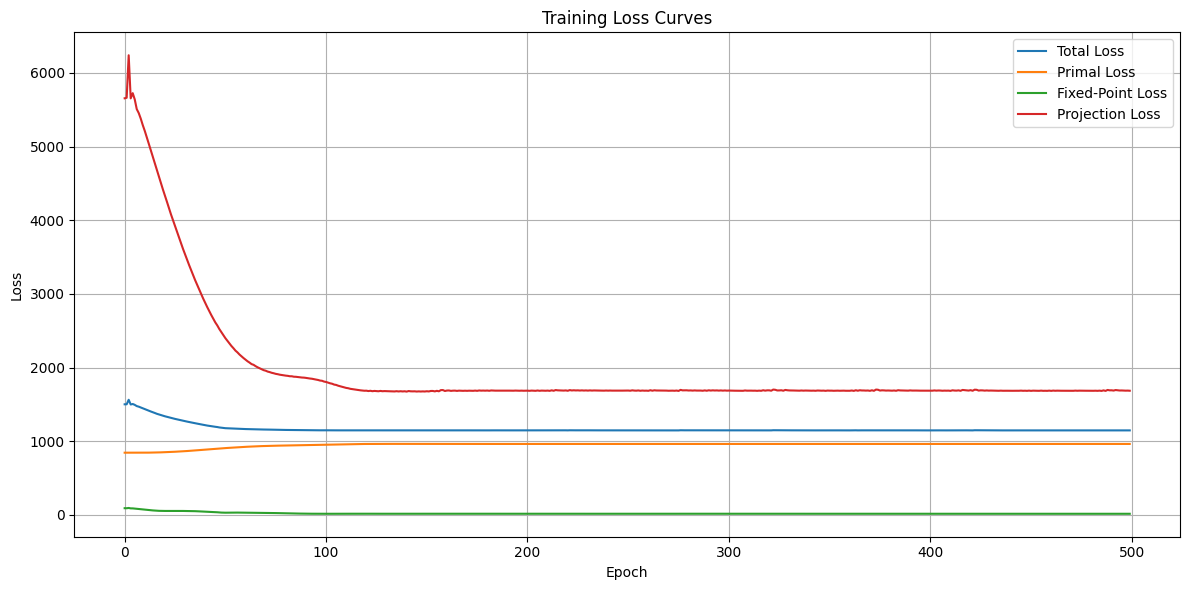

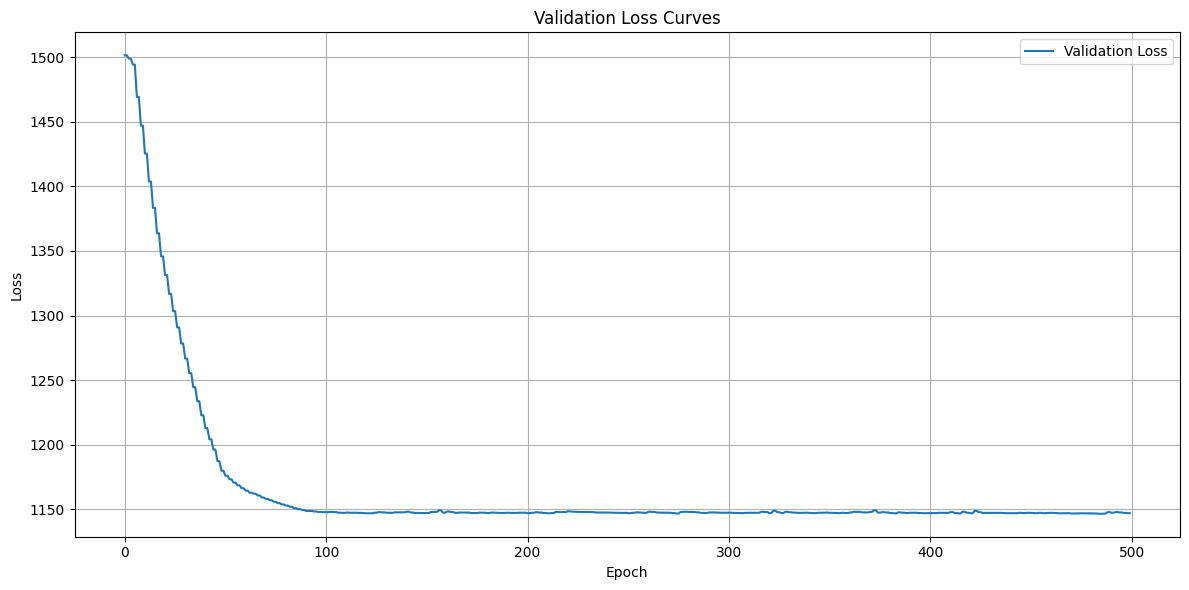

In [9]:
# Plot training losses

plt.figure(figsize=(12, 6))

plt.plot(avg_train_loss, label='Total Loss')
plt.plot(avg_primal_loss, label='Primal Loss')
plt.plot(avg_fixed_point_loss, label='Fixed-Point Loss')
plt.plot(avg_projection_loss, label='Projection Loss')


plt.title('Training Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot validation losses
plt.figure(figsize=(12, 6))
plt.plot(avg_val_loss, label='Validation Loss')

plt.title('Validation Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()